In [ ]:
#hide
# ! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
# import fastbook
# fastbook.setup_book()

In [1]:
from fastai.imports import *
from fastkaggle import *

In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Tabular Modeling Deep Dive

## Categorical Embeddings

## Beyond Deep Learning

## The Dataset

### Kaggle Competitions

In [ ]:
# creds = ''

In [ ]:
# cred_path = Path('~/.kaggle/kaggle.json').expanduser()
# if not cred_path.exists():
#     cred_path.parent.mkdir(exist_ok=True)
#     cred_path.write_text(creds)
#     cred_path.chmod(0o600)

In [3]:
# Download data for competitions
import zipfile, kaggle

In [4]:
competition = 'bluebook-for-bulldozers'

In [5]:
path_to_download = Path("../../kaggle_datasets")

In [6]:
if not path_to_download.exists(): # if the path to download datasets does not exist create
    path_to_download.mkdir(exist_ok=True)
    print(f"created path: {path_to_download}")
else:
    print("Dir already exists")

Dir already exists


In [12]:
# access the kaggle api keys
api = import_kaggle()

In [10]:
# define path to store data
path = path_to_download/competition
path

Path('../../kaggle_datasets/bluebook-for-bulldozers')

In [14]:
if not path.exists():
    api.competition_download_cli(competition=str(competition), path=path_to_download) # pass the competition name and the path to save the file
    zipfile.ZipFile(f'{path_to_download/competition}.zip').extractall(str(path_to_download/competition)) # find the path to the zip file, and then extract contents to the path
    print("Files downloaded succesfully")
else:
    print(f"The path {path} already exists...")

100%|██████████████████████████████████████████████████████████████████████████████| 48.4M/48.4M [00:01<00:00, 32.5MB/s]



Files downloaded succesfully


In [6]:
# list text files in directory
path.ls(file_type='text')

(#7) [Path('../../kaggle_datasets/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('../../kaggle_datasets/bluebook-for-bulldozers/median_benchmark.csv'),Path('../../kaggle_datasets/bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('../../kaggle_datasets/bluebook-for-bulldozers/Test.csv'),Path('../../kaggle_datasets/bluebook-for-bulldozers/TrainAndValid.csv'),Path('../../kaggle_datasets/bluebook-for-bulldozers/Valid.csv'),Path('../../kaggle_datasets/bluebook-for-bulldozers/ValidSolution.csv')]

### Look at the Data

In [7]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [8]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [9]:
df.head().iloc[:,:8]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0


In [11]:
df.dtypes

SalesID                int64
SalePrice            float64
MachineID              int64
ModelID                int64
datasource             int64
                      ...   
Backhoe_Mounting      object
Blade_Type            object
Travel_Controls       object
Differential_Type     object
Steering_Controls     object
Length: 53, dtype: object

In [12]:
df.describe(include=np.number)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


In [13]:
df.describe(include='object')

,UsageBand,saledate,fiModelDesc,fiBaseModel,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
count,73670,412698,412698,412698,...,81875,81877,71564,71522
unique,3,4013,5059,1961,...,10,7,4,5
top,Medium,2/16/2009 0:00,310G,580,...,PAT,None or Unspecified,Standard,Conventional
freq,35832,1932,5348,20179,...,39633,71447,70169,70774


In [14]:
# check the time range of the data
pd.to_datetime(df['saledate']).min(), pd.to_datetime(df['saledate']).max()

(Timestamp('1989-01-17 00:00:00'), Timestamp('2012-04-28 00:00:00'))

In [15]:
# handle ordinal columns, which have some natural ordering
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [9]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [10]:
df['ProductSize'] = df['ProductSize'].astype('category') # creates categories

In [11]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [12]:
df['ProductSize']= df['ProductSize'].cat.set_categories(sizes, ordered=True) # sets categories to be ordered (from largest to smallest)

In [13]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [14]:
# In the competition the metric is measured using root mean squared log error (RMSLE) which means we need
# to preprocess the SalePrice to a log value

dep_var = 'SalePrice'

In [15]:
df[dep_var] = np.log(df[dep_var])

## Decision Trees

### Handling Dates

In [23]:
# create metadata columns for handling dates such as holiday, day of week, month, etc. Fastai provides a function for this
df['saledate'].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

In [16]:
df = add_datepart(df, 'saledate')

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [25]:
# we added 13 more features based on the date
L([i for i in df.columns if i.startswith('sale')])

(#13) ['saleYear','saleMonth','saleWeek','saleDay','saleDayofweek','saleDayofyear','saleIs_month_end','saleIs_month_start','saleIs_quarter_end','saleIs_quarter_start'...]

In [17]:
# Preprocess the test set as well
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

/home/kinwaing/miniconda3/envs/py38/lib/python3.8/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [18]:
len(df),len(df_test)

(412698, 12457)

In [28]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Using TabularPandas and TabularProc

In [30]:
df.saleYear.unique()

array([2006, 2004, 2011, 2009, 2008, 2005, 2007, 2010, 2000, 2002, 1994, 1993, 1995, 1998, 1996, 1997, 1999, 2003, 1989, 1992, 2001, 1990, 1991, 2012], dtype=int32)

In [15]:
# Create a train and validaiton data. Since timeseries problem, we must make sure that the validation data occurs in the future

cond = (df.saleYear<2011) | ((df.saleMonth<11) & (df.saleYear == 2011)) # our split condition is if less than 2011 or also if equal to 2011 and the month is less than November 
train_idx = np.where(cond)[0] # the training data must match the condition
valid_idx = np.where(~cond)[0] # the validation data must match the opposite

splits = (list(train_idx),list(valid_idx))

In [16]:
len(train_idx), len(valid_idx)

(395371, 17327)

In [34]:
# dummy = df[cond]
# dummy['date'] = dummy['saleYear'].astype(str) + '-' + dummy['saleMonth'].astype(str)
# dummy['date'].sort_values().unique()

In [35]:
# Use fast ai function to find the continuous and categorical variables

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [38]:
len(cont), len(cat)

(14, 50)

In [46]:
# Use TabularPandas object which behaves like Datasets object 

# Preprocess tabular data with fastai to handle categorical variables and missing values
# Categorify replaces a column with a numeric categorical column
# FillMissing replaces missing values with the median of the column and also create a new Boolean column to indicate if the value was missing
procs = [Categorify, FillMissing]

# For categorical data, missing values will have a special na label, for continuous it will use the median

to = TabularPandas(df=df, # dataframe
                   procs=procs,  # processing steps
                   cat_names=cat, # name of categorical
                   cont_names=cont, # name of continuous
                   y_names=dep_var,  # name of dependent variable 
                   splits=splits # indices for splits
                  )

In [47]:
len(to.train),len(to.valid)

(395371, 17327)

In [80]:
# check if our dates conditions are correct
(df
 [['SalesID','saleYear','saleMonth', 'saleDay']] # subset of cols
 .assign(newdate=pd.to_datetime(df.saleYear.astype(str) + '-' + df.saleMonth.astype(str) + '-' + df.saleDay.astype(str))) # create new date
 [~cond] # subset data by condition
 ['newdate'] # index column
 .agg(['min', 'max'])
)

min   2011-11-01
max   2012-04-28
Name: newdate, dtype: datetime64[ns]

In [81]:
# categorical data is displayed with labels, however the underlying items are numeric

to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [ ]:
# to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
# to1.show(3)

In [84]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [ ]:
# to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

In [85]:
# we can access the classes
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [87]:
to.classes['UsageBand']

['#na#', 'High', 'Low', 'Medium']

In [89]:
# Save the preprocessed dataset for later use with Python's pickle

save_pickle(path/'tabular_object.pkl',to)

### Creating the Decision Tree

In [19]:
#hide
to = load_pickle(path/'tabular_object.pkl')

In [20]:
# define the independent and dependent variables for both train and validation

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [21]:
xs.shape, y.shape

((395371, 66), (395371,))

In [22]:
valid_xs.shape, valid_y.shape

((17327, 66), (17327,))

In [98]:
# To keep it simple create a tree with only 4 leaves
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

In [100]:
# draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [102]:
# samp_idx = np.random.permutation(len(y))[:500]
# dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

In [61]:
# After visual inspection, it was found that bulldozers with missing year made were assigned 1000
# Thus, we will change this to be 1950 for all bulldozers with yearmade before 1900

xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [104]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

# dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
#         fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#         orientation='LR')

In [105]:
# create a bigger tree using the default params
m = DecisionTreeRegressor()
m.fit(xs, y);

In [23]:
# create a rmse metric and also a function to get the rmse for the model
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [107]:
# we are checking on training, so of course our error will be zero
m_rmse(m, xs, y)

0.0

In [108]:
# on validation, our error is worse
# And we are overfitting pretty badly
m_rmse(m, valid_xs, valid_y)

0.366911

In [110]:
# We have almost as many leaves as we have samples (bad!)
m.get_n_leaves(), len(xs)

(317449, 395371)

In [111]:
# change the stopping criteria to build a tree with at least 25 samples at each leaf
# Much better since train and val loss are close

m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.241408, 0.339022)

In [112]:
m.get_n_leaves()

12098

### Categorical Variables

## Random Forests

In [ ]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

In [24]:
# n_stimators: the number of trees we want 
# max_samples: how many rows to sample for training each tree
# max_features: how many columns to sample at each split (o.5 means take half the total number of columns)
# min_samples_leaf: stopping criterion, specifies the minimum number of samples in each leaf
# n_jobs=-1 tells sklearn to use all our CPUs to build trees in parallel

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [29]:
m = rf(xs, y);

In [30]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170269, 0.244699)

In [ ]:
# dafault values tend to work pretty well for random forests with large number of trees
# max samples can be left as default unless you have over 200,000 samples, in which case 200,000 will make it faster to train
# max_features to 0.5 and min_samples_leaf=4 tend to work well

# preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [ ]:
# r_mse(preds.mean(0), valid_y)

In [ ]:
# plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

In [118]:
# A technique that helps to mitigate overfitting or having validation set cover a different time period
# OOB is a way of measuring prediction error on the training set by only including the calculation of a row's error trees
# where that row was not included in training. Every tree has its own validation set (the rows that were not selected for the tree's training)

# Only useful for small amount of training data. The predictions can be found as below
# The OOB error is much lower than our validation set, which means something else is causing the error in addition to normal generalization
r_mse(m.oob_prediction_, y)

0.210343

## Model Interpretation

### Tree Variance for Prediction Confidence

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [120]:
preds.shape

(40, 17327)

In [121]:
preds_std = preds.std(0)

In [122]:
preds_std[:5]

array([0.30103045, 0.18828805, 0.25003402, 0.18735091, 0.22356364])

### Feature Importance

In [28]:
'''
Extract the feature importance from the random forest
The features are ordered in the same way as the columns of our dataframe
'''

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [31]:
'''
Look at the 10 most importance features of the data
'''

fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.178298
6,ProductSize,0.111577
30,Coupler_System,0.109186
7,fiProductClassDesc,0.070472
54,ModelID,0.059869
65,saleElapsed,0.051782
32,Hydraulics_Flow,0.050943
3,fiSecondaryDesc,0.040328
31,Grouser_Tracks,0.037507
12,Enclosure,0.035018


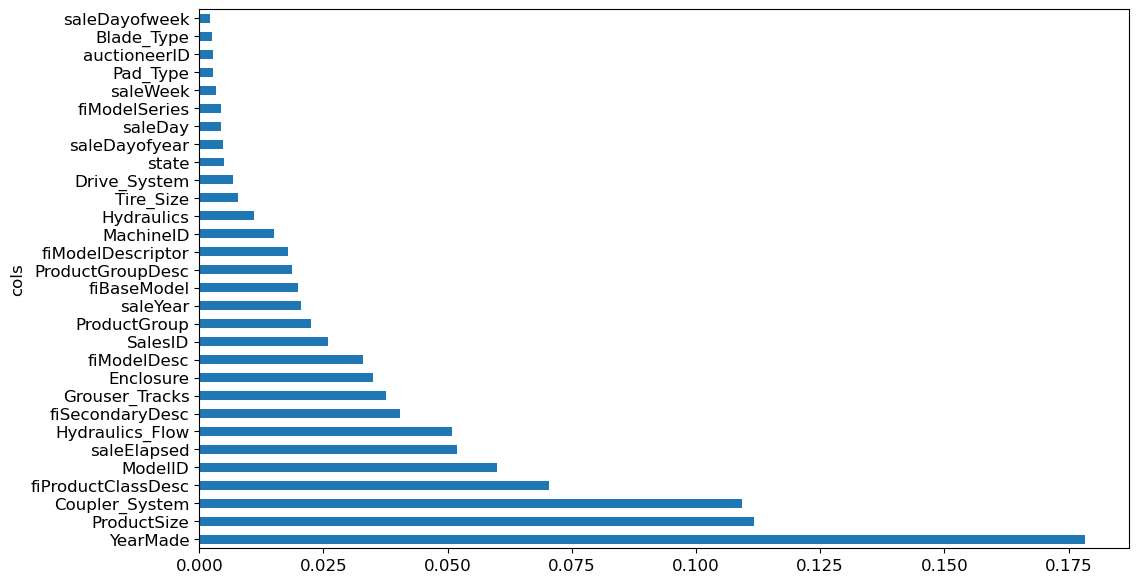

In [29]:
'''
Use pandas plot function to plot 30 columns
'''
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

In [27]:
'''
Keep features with importance greater than 0.005
'''

to_keep = fi[fi.imp>0.005].cols
len(to_keep)

NameError: name 'fi' is not defined

In [62]:
'''
Retrain model using data only for features to keep
'''

xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [63]:
m = rf(xs_imp, y)

In [64]:
'''
The accuracy is about the same but with less features to study
'''

m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.180582, 0.244577)

In [65]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

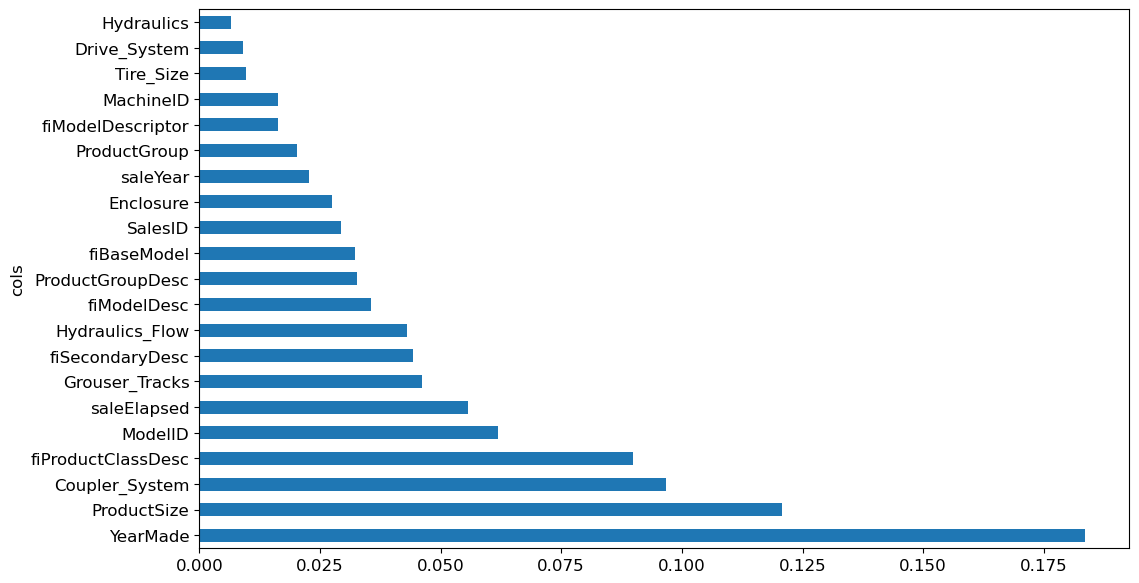

In [40]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

In [41]:
cluster_columns??

Signature: cluster_columns(df, figsize=(10, 6), font_size=12)
Docstring: <no docstring>
Source:   
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
File:      ~/miniconda3/envs/py38/lib/python3.8/site-packages/fastbook/__init__.py
Type:      function

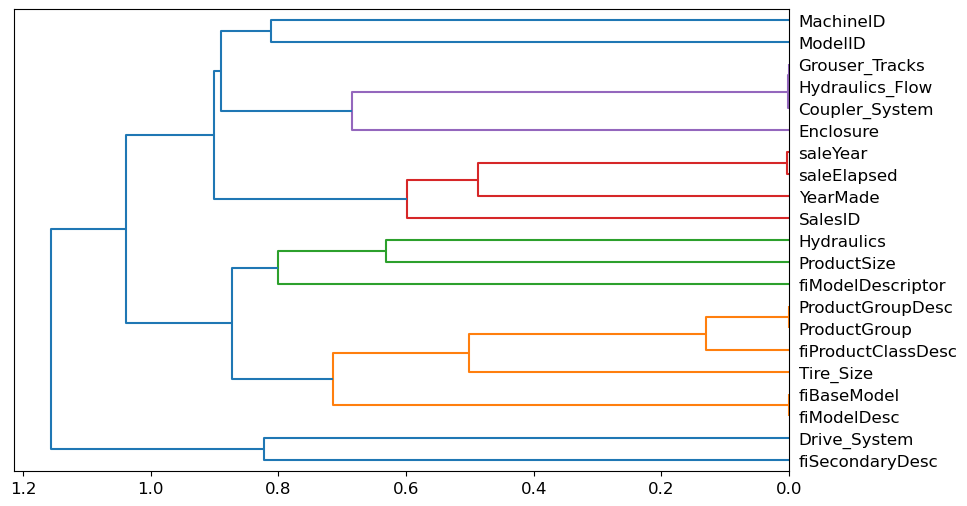

In [42]:
'''
There are features that are redundant/correlated
Let's cluster them to find out which features are redundant
The clustering we are running is bottom to top, that is we first group individual elements and keep increasing the clusters
Those elements merged early in the process are the most similar
The distance function is spearmean correlation (looking at ranks)
For example: saleYear and saleElapsed, productgroupdesc and productgroup, fibasemodel and fimodeldesc were merged very early
'''

cluster_columns(xs_imp)

In [32]:
'''
Function to train models and compared their oob score (or R^2)
For each model we will remove certain features to measure their impact in the scores
'''

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [44]:
'''
The baseline users all features
'''

get_oob(xs_imp)

0.8777850726830261

In [45]:
'''
We test some of the features that seem highly correlated and drop them from the dataset
Then we compute the oob score and store in a dict
'''
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8770310473349886,
 'saleElapsed': 0.872511626558208,
 'ProductGroupDesc': 0.8781713111708783,
 'ProductGroup': 0.8772012954455901,
 'fiModelDesc': 0.8756757390566937,
 'fiBaseModel': 0.8766631502693559,
 'Hydraulics_Flow': 0.8781891711691147,
 'Grouser_Tracks': 0.8778892471729695,
 'Coupler_System': 0.8777815499691122}

In [66]:
'''
Try dropping multiple variables at once
The score is not much different from our baseline which means it is safe to remove these features
'''

to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8752615925525968

In [67]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [68]:
xs_final.head()

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,...,MachineID,Hydraulics,Tire_Size,Drive_System
0,2004,0,0,59,...,999089,1,17,0
1,1996,3,0,62,...,117657,1,12,0
2,2001,0,1,39,...,434808,4,0,0
3,2001,4,0,8,...,1026470,1,0,0
4,2007,0,1,40,...,1057373,4,0,0


In [69]:
'''
We can create dataframes with these features for both our train and validation
And saved them for later use
'''

save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [33]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [34]:
'''
Let's check the performance on our rmse metric
We have greatly simplified the model without loosing much accuracy
'''

m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.182589, 0.247105)

### Partial Dependence

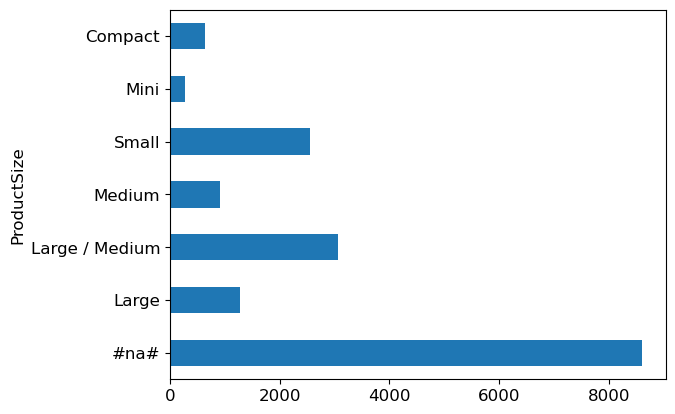

In [51]:
'''
Productsize and yearmade are the most important predictors
And we want to understand the relationship between these predictors and our dependent variable

The largest group us na which is the label for missing values
'''

p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

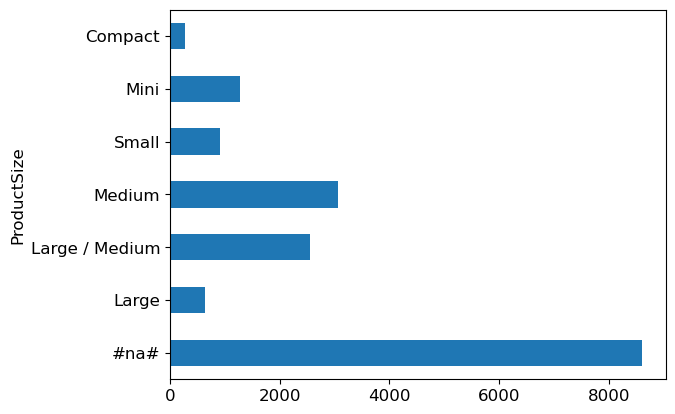

In [52]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).sort_index().plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

In [36]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [48]:
to.classes['state'][32]

'New York'

In [45]:
'''
Checking the actual integers assigned to the values of ProductSize 
'''
to.train.items.head(3)[['fiModelDescriptor','ProductSize', 'state']]

,fiModelDescriptor,ProductSize,state
0,0,0,1
1,0,3,33
2,0,0,32


In [46]:
to.train.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


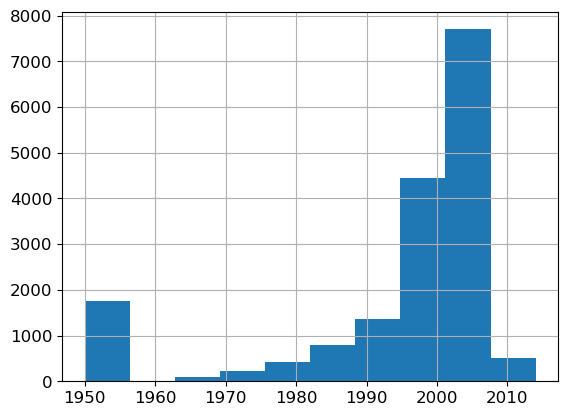

In [73]:
'''
Most data is from after 1990 except for those missing values which we coded to 1950
'''

ax = valid_xs_final['YearMade'].hist()

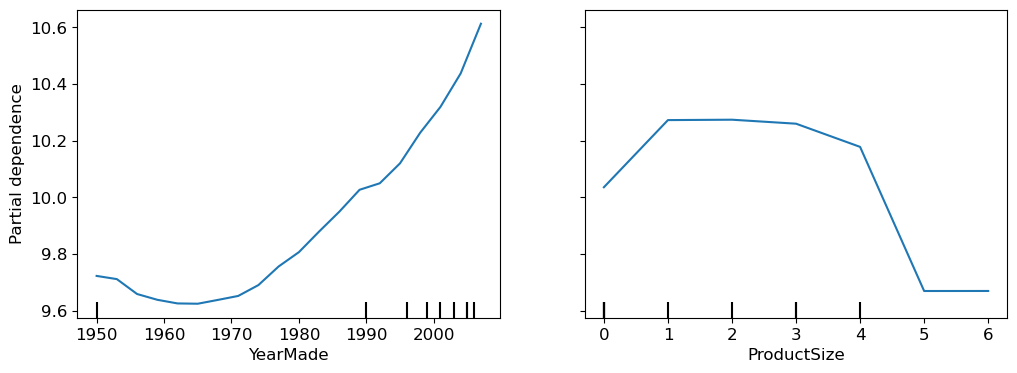

In [76]:
'''
Partial dependence plots try to answer: if the row (sample) varied on nothing other than the feature in question, 
how would it impact the dependent variable?
Why does averaging sale price for each year made would not answer the question? Many other factors vary from year to year,
this means that averaging over all auctions that have the same year would also capture the effect of how every other field changed

What we do is replace every single value in the year made column with the exact same year, and the compute the predicted sale
price for every auction and take the average over all auctions. This way we are isolating the effect of only year made
even if the average is over some imagined records...(causality)
'''

'''
From yearmade, we see that there is almost a linear relationship between sale price and year made after 1990. 
Because our sale price if shown after taking the log, we can say that there is actually an exponential increase in price
Year made has an exponential relationship with sale price

The productsize is a bit concerning. The first category is for missing values and it does not follow the normal trend
Larger bulldozers are tipically more expensive
The NaN category is a mixed bag 
'''
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Data Leakage

In [53]:
'''
The information about the target of a data mining problem which should not be legitimately available to mine from
A trivial example, the model uses the target itself as input
Missing values can represent data leakage

Data that is not available at the time a decision needs to be made is leaked into the training, resulting in a highly 
predictive model, but leveraging signals that are not available at the time

Advise: build a model first and then perform data cleaning, rather than vice versa. The model can help to identify problematic datasets

'''

'\nThe information about the target of a data mining problem which should not be legitimately available to mine from\nA trivial example, the model uses the target itself as input\nMissing values can represent data leakage\n\nData that is not available at the time a decision needs to be made is leaked into the training, resulting in a highly \npredictive model, but leveraging signals that are not available at the time\n\nAdvise: build a model first and then perform data cleaning, rather than vice versa. The model can help to identify problematic datasets\n\n'

### Tree Interpreter

In [54]:
'''
For a single row of data, we need to put it through our built decision trees
We will look at what split is used at each point in the tree
For each split, we see what the increase or decrease in the addition is compared to the parent node
We add the total change in importance by split variable across all trees


Important information in production rather than model development as it five us insights about
the underlying reasoning of predictions
'''

'\nFor a single row of data, we need to put it through our built decision trees\nWe will look at what split is used at each point in the tree\nFor each split, we see what the increase or decrease in the addition is compared to the parent node\nWe add the total change in importance by split variable across all trees\n'

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation and Neural Networks

### The Extrapolation Problem

In [55]:
#hide
np.random.seed(42)

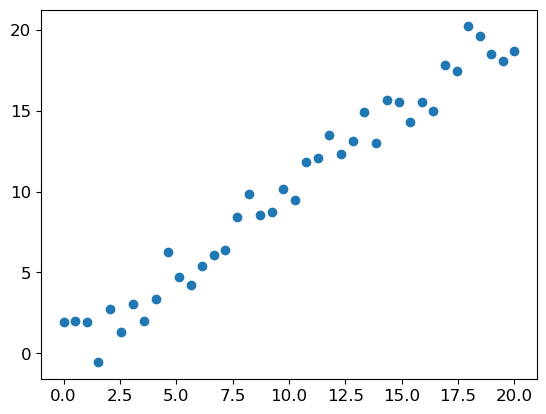

In [56]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [57]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [58]:
x_lin[:,None].shape

torch.Size([40, 1])

In [59]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

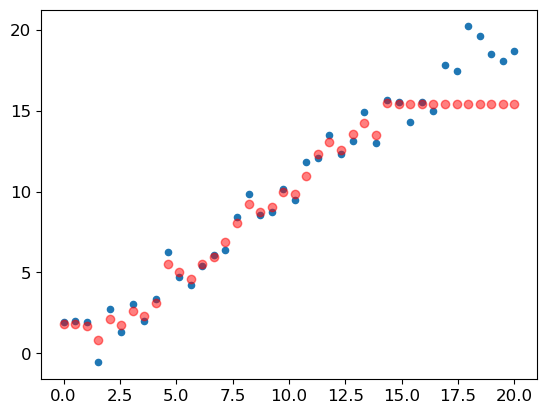

In [60]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [ ]:
'''
Problem with random forests

The predictions outside of the domain of data are all too low
Why? these values are never seen in training and the random forest can only predict the average

A tree and a random forest can never predict values outside of the range of the training data
Random forests can't extrapolate outside of the types of data they have seen (that's why we need to make sure
the validation set does not contain out-of-domain data)
'''

### Finding Out-of-Domain Data

In [61]:
'''
Use random forest to predict whether one row is in the validation set or in the training set 

There are three columns that differ significantly from the training and validation, and they are obvious as
they are related to time
'''

df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.747254
10,SalesID,0.176611
13,MachineID,0.070149
0,YearMade,0.003770
8,Enclosure,0.000850
4,ModelID,0.000335


In [62]:
'''
Build a model that drops these time-dependent columns
'''

m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.246552
SalesID 0.24468
saleElapsed 0.249694
MachineID 0.246167


In [63]:
'''
Removing these variables can improve the model's accuracy, but more importantly, it should make it more resilient over time

Recommendation: for all datasets, build a model where the dependent variable is is_valid, as it can often uncover
subtle domain shift issues that can be missed otherwise

Another thing that can help is avoid old data as those relationships may not be valid anymore
'''

time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.242901

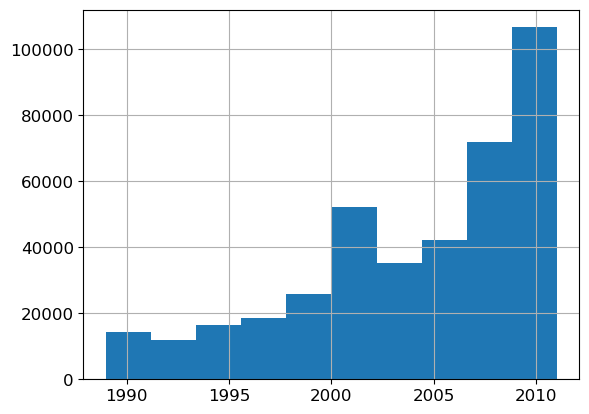

In [64]:
xs['saleYear'].hist();

In [65]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [66]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.176118, 0.242578)

### Using a Neural Network

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
cont_nn

In [ ]:
df_nn_final[cat_nn].nunique()

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

In [ ]:
cat_nn.remove('fiModelDescriptor')

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

In [ ]:
learn.save('nn')

### Sidebar: fastai's Tabular Classes

### End sidebar

## Ensembling

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
r_mse(ens_preds,valid_y)

### Boosting

### Combining Embeddings with Other Methods

## Conclusion: Our Advice for Tabular Modeling

## Questionnaire

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide two of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kinds of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?
1. What is "out-of-bag-error"?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the "extrapolation problem"?
1. How can you tell if your test or validation set is distributed in a different way than your training set?
1. Why do we ensure `saleElapsed` is a continuous variable, even although it has less than 9,000 distinct values?
1. What is "boosting"?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

### Further Research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the dataset you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).